# Libraries

In [254]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from wordcloud import WordCloud
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

# Tokenizing
nltk.download('punkt')
# Stopwords removal
nltk.download('stopwords')
# Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Completed')

Completed


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TrisnaWahyudi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TrisnaWahyudi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TrisnaWahyudi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TrisnaWahyudi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\TrisnaWahyudi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [255]:
# get slang word data from github
indo_slang_word = pd.read_csv('../datasets/utils/indo_slang_word.csv')
indo_slang_word.head()

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0


# Preprocessing methods

## Cleaning


In [256]:
def cleaning(text):
    # Case folding
    text = text.lower()
    # Trim text
    text = text.strip()
    # Remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    # Remove punctuations, special characters, and double whitespace
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Number removal
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers and whitespaces
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

In [257]:
def handle_negation(review):
    # Membuat pola regular expression untuk menemukan kata "tidak" dan kata-kata setelahnya
    negation_pattern = re.compile(r'\btidak\b\s+(\w+)')

    # Menggabungkan kata-kata setelah kata "tidak" dengan tanda garis bawah
    modified_review = negation_pattern.sub(lambda match: 'tidak' + match.group(1), review)
    
    return modified_review

## Tokenization

In [258]:
from nltk.tokenize import word_tokenize

## Word Normalization

In [259]:
def replace_slang_word(doc):
    for index in range(0,len(doc)-1):
        index_slang = indo_slang_word.slang==doc[index]
        formal = list(set(indo_slang_word[index_slang].formal))
        if len(formal)==1:
            doc[index]=formal[0]
    return doc

## Stopword removal

In [260]:
filtering = stopwords.words('indonesian')
def stopword_removal(review):

    x = []
    data = []
    def myFunc(x):
      if x in filtering:
        return False
      else:
        return True

    fit = filter(myFunc, review)
    for x in fit:
      data.append(x)

    return data

## Stemming

In [261]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Menerapkan stemming pada setiap kata dalam daftar tokens
tqdm.pandas(desc="Proses Stemming")

## Preprocessor

In [262]:
def data_preprocessor(data):
  tqdm.pandas(desc="Proses Cleaning")
  data['review'] = data['review'].progress_apply(lambda x: cleaning(x))
  
  tqdm.pandas(desc="Proses Negation Handling")
  data['review'] = data['review'].progress_apply(lambda x: handle_negation(x))
  
  tqdm.pandas(desc="Proses Tokenizing")
  data['review'] = data['review'].progress_apply(lambda x: word_tokenize(x))
  
  tqdm.pandas(desc="Proses Word Normalizing")
  data['review'] = data['review'].progress_apply(lambda x: replace_slang_word(x))
  
  tqdm.pandas(desc="Proses Stopword Removal")
  data['review'] = data['review'].progress_apply(stopword_removal)
  
  tqdm.pandas(desc="Proses Stemming")
  data['review'] = data['review'].progress_apply(lambda x: [stemmer.stem(word) for word in x])
  data["review"] = data["review"].apply(' '.join)
    
  return data

# Datasets Preprocessing

In [263]:
review_1 = pd.read_csv('../datasets/review_aplikasi_signal_bintang_1.csv')
review_5 = pd.read_csv('../datasets/review_aplikasi_signal_bintang_5.csv')

#  Data Labeling
review_1["label"] = 'negative'
review_5["label"] = 'positive'

# Combine dataframes
df_combined = pd.concat([review_1, review_5])


df_combined["review"] = df_combined["content"]
df_combined = df_combined.drop(["userName", "score", "at", "content"], axis=1)


df_combined.head()

,label,review
0,negative,parah stnk belum dikirim transaksi udah di ang...
1,negative,Ribet. Makin bikin malas bayar pajak
2,negative,Aplikasi pembodohan verifikasi data selalu tid...
3,negative,Susah dlm pembayaran.kode pembayaran selalu sa...
4,negative,Saya sudah bayar ongkir yg express tapi tdk di...


In [264]:
# save combined dataset as new csv file
df_combined.to_csv('../datasets/review_aplikasi_signal.csv', index=False)

## Clustering Datasets

In [265]:
df = pd.read_csv('../datasets/review_aplikasi_signal.csv')
df.head(10)

,label,review
0,negative,parah stnk belum dikirim transaksi udah di ang...
1,negative,Ribet. Makin bikin malas bayar pajak
2,negative,Aplikasi pembodohan verifikasi data selalu tid...
3,negative,Susah dlm pembayaran.kode pembayaran selalu sa...
4,negative,Saya sudah bayar ongkir yg express tapi tdk di...
5,negative,Saya Heran kenapa aplikasi tidak layak guna se...
6,negative,buruk dan lama proses pengirimanya
7,negative,3x gagal transaksi saat pakai menu kirim paket...
8,negative,Tanpa kejelasan berapa hari kerja pengiriman S...
9,negative,Aplikasi gabisa di pakai


In [266]:
df_clean = data_preprocessor(df)
df_clean.head()

Proses Stemming: 100%|██████████| 10000/10000 [10:13<00:00, 16.30it/s]


,label,review
0,negative,parah stnk kirim transaksi anggap selesai ming...
1,negative,ribet bikin malas bayar pajak
2,negative,aplikasi bodoh verifikasi data tidakvalid baru...
3,negative,susah bayar kode bayar salah input sesuai kode...
4,negative,bayar ongkir express kirim jemput bola ongkir ...


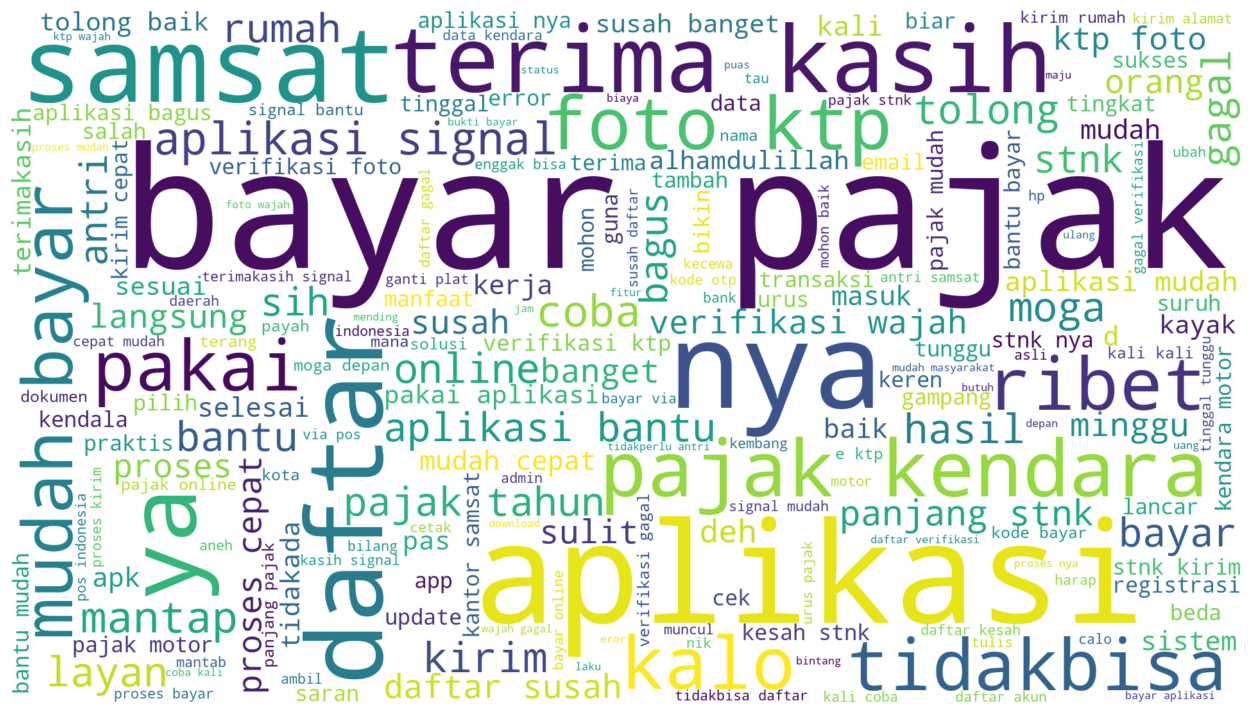

In [267]:
# word cloud
text_data = " ".join(df_clean['review'])

wordcloud = WordCloud(width=1920, height=1080, max_words=200, background_color='white').generate(text_data)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [268]:
# save data to csv file
df_clean.to_csv('../datasets/clean/clean_dataset.csv', index=False)